<a href="https://colab.research.google.com/github/prashun07/Detecting-and-Localizing-pneumonia-/blob/master/CNN%26ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#About Dataset

The Dataset is downloaded from Kaggle.
Link:https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
 


The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.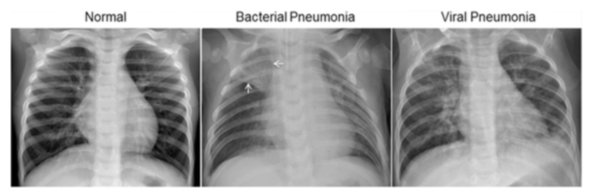


#Steps to tackle the problem.

*   Import the Utilities
*  Write GPU utilities
* Prepare data for CNN
* CNN Model design
* Training CNN
* Testing result on test dataset
* Using **Transfer** **Function**
* Residual Neural Network (**ResNET** **152**)
* **CAM** Algorithms
* Test result





#**Import** **Utilities**

In [ ]:
#These are some basic Utilites we will need.
import os #To handle dataset
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import ImageFolder #to load data from folder
from torch.utils.data import DataLoader 
import torchvision.transforms as tt #to tansform image into tensors
from torch.utils.data import random_split #for spliting dataset into train and validation set
from torchvision.utils import make_grid 

#to draw images in notebook
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'


#**GPU** **Utilities**

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

#**Download** **and** **Load** **Dataset**.

In [ ]:

!pip install opendatasets --upgrade --quiet
import opendatasets as od #used to download the datasets

**Here**,I am going to download dataset from the kaggle.
the link is in below cell or see the first cell of the notebook.
Before, you run the cell below please upload your kaggle profile details.
Either upload Kaggle API or sign in here with your kaggle username and password.
kaggle API can be created here:
visit kaggle->your profile->Account->create new API
now dounload this API and upload to the colab.

In [ ]:
dataset_url='https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia'
od.download(dataset_url) #size of dataset is around 2.29GB but dont worry it will take just few seconds to download 

  0%|          | 5.00M/2.29G [00:00<01:28, 27.8MB/s]

100%|██████████| 2.29G/2.29G [00:28<00:00, 85.4MB/s]


If you have downloaded the data in your local device then, you can use it by first uploading it to the Colab.
I have directly downloaded the dataset in the colab.But,Data will be lost after runtime disconnection or on refreshing the page and you may need to upload it again.


In [ ]:
data_dir='/content/chest-xray-pneumonia/' #data_dir has path of the downloaded data

In [ ]:
import shutil #python module used here to handle error in dataset

In [ ]:
os.listdir(data_dir+'chest_xray')

['val', 'test', 'train']

As you can see the output of above cell, there is 5 subfolder in dataset.'chest_xray' is repetiton of previous chest_xray folder which is error.
'__MACOSX' is unnecessary folder. so, lets remove these two folder using shutil module.


In [ ]:
shutil.rmtree(data_dir+'chest_xray/__MACOSX')

In [ ]:
shutil.rmtree(data_dir+'chest_xray/chest_xray')

In [ ]:
data_dir=data_dir+'chest_xray'
os.listdir(data_dir)

['val', 'test', 'train']

Now dataset has only 3 folders which is required for the process.

In [ ]:
dataset=ImageFolder(data_dir)#to load folder

In [ ]:
len(dataset)

5856

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=1857x1317 at 0x7F6A4A6225D0>, 0)

Here,you can see that dataset contains an Image and Label of image.

In [ ]:
dataset.classes

['test', 'train', 'val']

lets visualize the some image of the dataset.

0


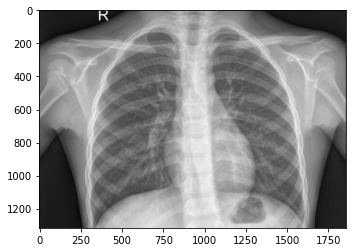

In [ ]:
img,lab=dataset[0] #take image and label from dataset
plt.imshow(img)#print image
print(lab)

0


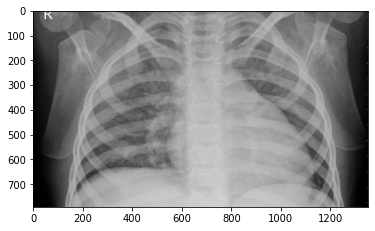

In [ ]:
img,lab=dataset[500]
plt.imshow(img)
print(lab)

1


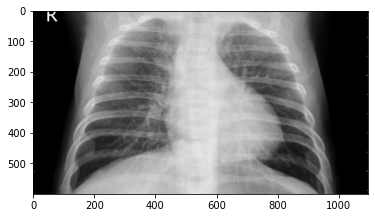

In [ ]:
img,lab=dataset[2500]
plt.imshow(img)
print(lab)

From the past three images you can clearly see that all these images have different size and some visual difference like darkness.
all images is in black and white.
so we got the first problem here to solve which make all these image similar in terms of size so that deep learning algorithms can be applied.

In [ ]:
for cls in os.listdir(data_dir+'/train'):
  print(cls,':',len(os.listdir(data_dir+'/train/'+cls)))

PNEUMONIA : 3875
NORMAL : 1341


In train folder,There is 1341 NORMAL labeled images whereas 3845 PNEUMONIA labeled images.

In [ ]:
for cls in os.listdir(data_dir+'/test'):
  print(cls,':',len(os.listdir(data_dir+'/test/'+cls)))

PNEUMONIA : 390
NORMAL : 234


In test folder,There is 234 NORMAL labeled images whereas 390 PNEUMONIA labeled images.

In [ ]:
for cls in os.listdir(data_dir+'/val'):
  print(cls,':',len(os.listdir(data_dir+'/val/'+cls)))

PNEUMONIA : 8
NORMAL : 8


In val folder,There is 8 NORMAL labeled images whereas 8 PNEUMONIA labeled images.

Now, it is time to convert image into tensor and also apply some other functions to improve the image dataset.
I am going to resize image into 64x64 size.You can also try by resizing it to 224x224.

visit this link to know more about functions used below.  https://pytorch.org/docs/stable/torchvision/transforms.html

**Prepare** **data** **For** **CNN**

In [ ]:
dataset = ImageFolder(data_dir+'/train', 
                      transform=tt.Compose([tt.Resize(64),#resize the image into 64x64
                                            tt.CenterCrop(64),#crop image from centre
                                            tt.RandomHorizontalFlip(),
                                            tt.RandomRotation(10),
                                            tt.RandomGrayscale(),
                                            tt.RandomAffine(translate=(0.05,0.05), degrees=0),# keep center invariant
                                            tt.ToTensor()
                                           ]))

So check the dataset[0]

In [ ]:
dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.3373, 0.3020, 0.2588,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0980,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0941,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.3373, 0.3020, 0.2588,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0980,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0941,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.3373, 0.3020, 0.2588,  ...,

image is converted into tensors.

#Visualize the data


torch.Size([3, 64, 64])
0


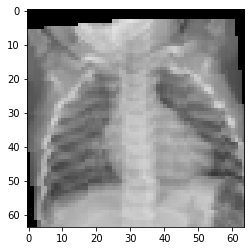

In [ ]:
#print image from tensor
img,label=dataset[50] 
plt.imshow(img.permute(1,2,0))
print(img.shape)
print(label)

0


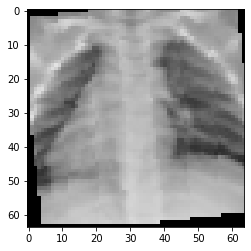

In [ ]:
img,label=dataset[5]
plt.imshow(img.permute(1,2,0))
print(label)

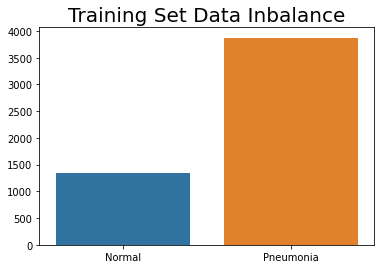

In [ ]:
# number of images for each class in train set

train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/train/NORMAL', filename) 
                     for filename in os.listdir(data_dir+'/train/NORMAL')])], 
     'Pneumonia': [len([os.path.join(data_dir+'/train/PNEUMONIA', filename) 
                        for filename in os.listdir(data_dir+'/train/PNEUMONIA')])]})


sns.barplot(data=train_samplesize).set_title('Training Set Data Inbalance', fontsize=20)
plt.show()

Traninig data is unbalanced.Normal labeled image is very less compared to Pneumonia labeled image.
Too much unbalanced data can be responsible for overfitting of model.

In [ ]:
#split dataset in train and validation dataset
val_size=1500
train_size=len(dataset)-val_size
train_data,val_data=random_split(dataset,[train_size,val_size])
len(train_data),len(val_data)

(3716, 1500)

In [ ]:
#Now,Lets take batch size=64 and load data into batches
batch_size=64
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_data, batch_size*2, num_workers=4, pin_memory=True)

making a grid of images in a batch.

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

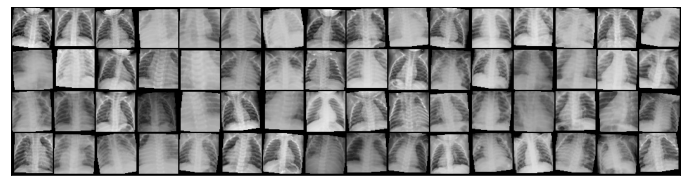

In [ ]:
show_batch(train_dl)

#Load data in GPU

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
#Load data into GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

**MODEL**

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 112 x 112

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4,4), # output: 128 x 28x 28

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d(4), # output: 256 x 4 x 4
            
            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 2))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model=to_device(CnnModel(),device)
model

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): AdaptiveMaxPool2d(output_size=4)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024, out_features=512, bias=True)
    (19):

In [ ]:
for batch in train_dl:
  images,labels=batch
  print('image shape',images.shape)
  print(images.device)
  preds=model(images)
  print('preds shape:',preds.shape)
  break

image shape torch.Size([64, 3, 64, 64])
cuda:0
preds shape: torch.Size([64, 2])


**Training**

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history=[evaluate(model,val_dl)]
history

[{'val_acc': 0.75730299949646, 'val_loss': 0.6770803928375244}]

In [ ]:
history+=fit(5,0.001,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.5852, val_loss: 0.5852, val_acc: 0.7573
Epoch [1], train_loss: 0.5787, val_loss: 0.5545, val_acc: 0.7573
Epoch [2], train_loss: 0.5804, val_loss: 0.5590, val_acc: 0.7573
Epoch [3], train_loss: 0.5327, val_loss: 0.3562, val_acc: 0.8117
Epoch [4], train_loss: 0.3007, val_loss: 0.2678, val_acc: 0.8977


In [ ]:
history+=fit(5,0.0001,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.2007, val_loss: 0.1670, val_acc: 0.9353
Epoch [1], train_loss: 0.1787, val_loss: 0.1597, val_acc: 0.9461
Epoch [2], train_loss: 0.1663, val_loss: 0.1484, val_acc: 0.9526
Epoch [3], train_loss: 0.1509, val_loss: 0.1422, val_acc: 0.9492
Epoch [4], train_loss: 0.1460, val_loss: 0.1402, val_acc: 0.9481


In [ ]:
history+=fit(5,0.0001,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.1447, val_loss: 0.1327, val_acc: 0.9525
Epoch [1], train_loss: 0.1366, val_loss: 0.1303, val_acc: 0.9499
Epoch [2], train_loss: 0.1350, val_loss: 0.1230, val_acc: 0.9550
Epoch [3], train_loss: 0.1294, val_loss: 0.1272, val_acc: 0.9555
Epoch [4], train_loss: 0.1253, val_loss: 0.1164, val_acc: 0.9573


In [ ]:
#function to plot accuracy
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

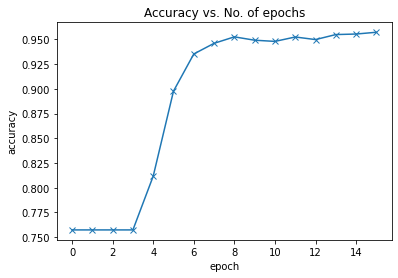

In [ ]:
plot_accuracies(history)

In [ ]:
#function to plot losses
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

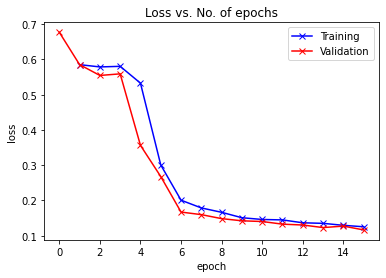

In [ ]:
plot_losses(history)

After 6 epochs Training and validation losses started flattening.
More Training will lead to overfitting of model.

**Testing** **model**

In [ ]:
#loading Test dataset to test the model
testset = ImageFolder(data_dir+'/test', 
                      transform=tt.Compose([tt.Resize(64),
                                            tt.CenterCrop(64),
                                            tt.RandomHorizontalFlip(),
                                            tt.RandomRotation(10),
                                            tt.RandomGrayscale(),
                                            tt.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            tt.ToTensor()
                                           ]))

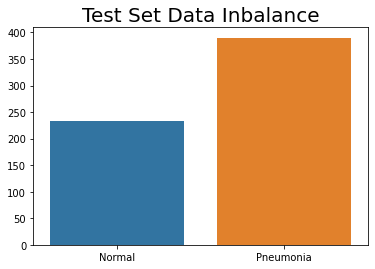

In [ ]:
# number of images for each class

test_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/test/NORMAL', filename) 
                     for filename in os.listdir(data_dir+'/test/NORMAL')])], 
     'Pneumonia': [len([os.path.join(data_dir+'/test/PNEUMONIA', filename) 
                        for filename in os.listdir(data_dir+'/test/PNEUMONIA')])]})


sns.barplot(data=test_samplesize).set_title('Test Set Data Inbalance', fontsize=20)
plt.show()

In [ ]:
# Evaluate test set
test_loader = DeviceDataLoader(DataLoader(testset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.7837053537368774, 'val_loss': 0.7984716892242432}

we got an accuracy of approx 78.70 % on test dataset.

Predict image

In [ ]:
def predict_image(img, model,classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

def show_predict(data):
   size=16
   for i in range(size):
     img,label=data[i] #Take image and label
     preds=predict_image(img,model,dataset.classes) #predict using predict_function
     #print image with predicted label and target
     fig, ax = plt.subplots(figsize=(12, 6))
     plt.subplot(4,4,1+i)
     plt.imshow(img.permute(1,2,0))
     print('Image number:',i,'Target:',dataset.classes[label])
     print('Predicted:',preds)
     plt.show()

Image number: 0 Target: NORMAL
Predicted: NORMAL


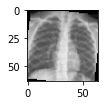

Image number: 1 Target: NORMAL
Predicted: PNEUMONIA


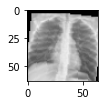

Image number: 2 Target: NORMAL
Predicted: PNEUMONIA


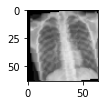

Image number: 3 Target: NORMAL
Predicted: PNEUMONIA


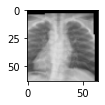

Image number: 4 Target: NORMAL
Predicted: PNEUMONIA


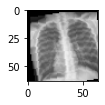

Image number: 5 Target: NORMAL
Predicted: NORMAL


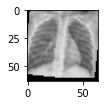

Image number: 6 Target: NORMAL
Predicted: NORMAL


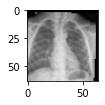

Image number: 7 Target: NORMAL
Predicted: NORMAL


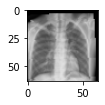

Image number: 8 Target: NORMAL
Predicted: NORMAL


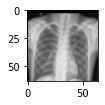

Image number: 9 Target: NORMAL
Predicted: NORMAL


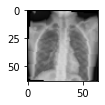

Image number: 10 Target: NORMAL
Predicted: NORMAL


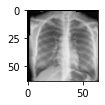

Image number: 11 Target: NORMAL
Predicted: PNEUMONIA


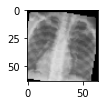

Image number: 12 Target: NORMAL
Predicted: NORMAL


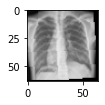

Image number: 13 Target: NORMAL
Predicted: PNEUMONIA


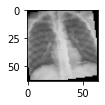

Image number: 14 Target: NORMAL
Predicted: PNEUMONIA


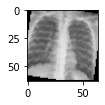

Image number: 15 Target: NORMAL
Predicted: PNEUMONIA


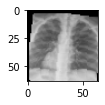

In [ ]:
show_predict(testset)

Model: Convolutional Neural Network

Image size:64x64

Batch_size=64

Epochs:15

Training accuracy:95.7%(approx)

Test accuracy:78.3%(approx)

#Transfer learning
Our goal in this section is to classify chest x-ray images as containing Pneumonia or not and draw class activation maps on discriminative regions used to identify the Pneumonia.

From previous CNN model we cannot know how our model predicted the data set just by looking at image.
we need to print image such that features are easily visiable for us.
Like the image below:



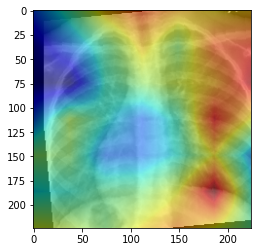

#Now,i am going to apply transfer learning to predict Image.
Pretrained model [Resnet152](https://towardsdatascience.com/review-resnet-winner-of-ilsvrc-2015-image-classification-localization-detection-e39402bfa5d8#:~:text=ResNet%20can%20have%20a%20very,learning%20the%20signal%20representation%20directly.&text=ImageNet%2C%20is%20a%20dataset%20of,images%20with%20around%2022%2C000%20categories.) is used for this purpose.

##MODEL ARCHITECTURE
Our base line model for this project is the ResNet 152. ResNet models like other convolutional network architectures consist of series of convolutional layers but designed in a way to favor very deep networks. The convolutional layers are arranged in series of Residual blocks. The significance of these Residual blocks is to prevent the problem of vanishing gradients which are very pervasive in very deep convolutional networks. Residual blocks have skip connections which allow gradient flow in very deep networks.

Building block of resnet(residual neural network)

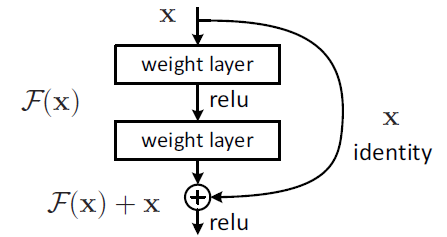


Here, i am going to take image of 224x224 size because with image of size 64x64 i got predicted image of very low resolution.
like the image below:


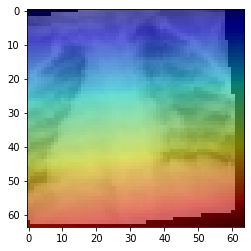

In [ ]:
dataset = ImageFolder(data_dir+'/train', 
                      transform=tt.Compose([tt.Resize((224,224)),
                                            #tt.CenterCrop(224),
                                            tt.RandomHorizontalFlip(),
                                            tt.RandomRotation(10),
                                            tt.RandomGrayscale(),
                                            tt.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            tt.ToTensor()
                                           ]))

In [ ]:
#split dataset in train and validation dataset
val_size=1500
train_size=len(dataset)-val_size
train_data,val_data=random_split(dataset,[train_size,val_size])
len(train_data),len(val_data)

(3716, 1500)

In [ ]:
#Now,Lets take batch size=64 and load data into batches
batch_size=64
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_data, batch_size*2, num_workers=4, pin_memory=True)

In [ ]:
#Load data into GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

#**Model**

In [ ]:
from torchvision import models

class TransferModel(ImageClassificationBase):
    def __init__(self):
        super(TransferModel, self).__init__()
        #obtain the ResNet model from torchvision.model library
        self.model = torchvision.models.resnet152(pretrained=True)
        #build our classifier and since we are classifying the images into NORMAL and PNEMONIA, we output a two-dimensional tensor.
        self.classifier = nn.Sequential(
        nn.Linear(self.model.fc.in_features,2),
        nn.LogSoftmax(dim=1))
        #Requires_grad = False denies the ResNet model the ability to update its parameters hence make it unable to train.
        for params in self.model.parameters():
            params.requires_grad = False
            #We replace the fully connected layers of the base model(ResNet model) which served as the classifier with our custom trainable classifier.
        self.model.fc = self.classifier

    def forward(self, x):
      return self.model(x)

In [ ]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)

In [ ]:
model1 = TransferModel()
to_device(model1, device);

In [ ]:
history1 = [evaluate(model1, valid_dl)]
history1

[{'val_acc': 0.28175950050354004, 'val_loss': 0.8559844493865967}]

**Training**

In [ ]:
epochs = 16
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history1 += fit_one_cycle(epochs, max_lr, model1, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], train_loss: 0.1578, val_loss: 0.1340, val_acc: 0.9546



Epoch [1], train_loss: 0.1601, val_loss: 0.1420, val_acc: 0.9440



Epoch [2], train_loss: 0.1498, val_loss: 0.1239, val_acc: 0.9600



Epoch [3], train_loss: 0.1571, val_loss: 0.1558, val_acc: 0.9346



Epoch [4], train_loss: 0.1671, val_loss: 0.1124, val_acc: 0.9606



Epoch [5], train_loss: 0.1583, val_loss: 0.1194, val_acc: 0.9537



Epoch [6], train_loss: 0.1295, val_loss: 0.1269, val_acc: 0.9521



Epoch [7], train_loss: 0.1324, val_loss: 0.1182, val_acc: 0.9556



Epoch [8], train_loss: 0.1358, val_loss: 0.1103, val_acc: 0.9589



Epoch [9], train_loss: 0.1297, val_loss: 0.1244, val_acc: 0.9530
CPU times: user 1min 32s, sys: 1min 3s, total: 2min 35s
Wall time: 12min 45s


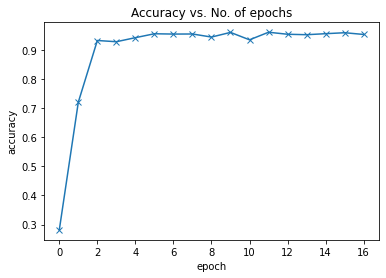

In [ ]:
 plot_accuracies(history1)

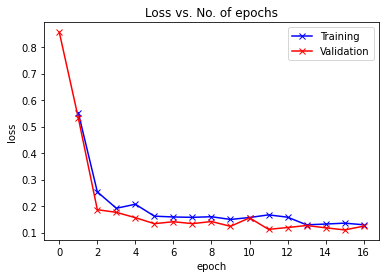

In [ ]:
plot_losses(history1)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

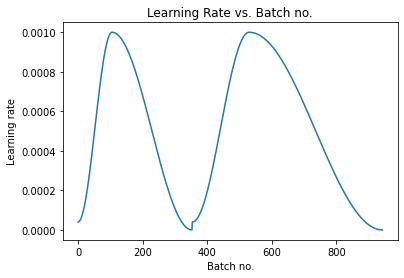

In [ ]:

plot_lrs(history1)

#**Class** **Activation** **Maps**

In [ ]:
class LayerActivations():
    features=[]
    def __init__(self,model):
        self.hooks = []
        #model.layer4 is the last layer of our network before the Global Average Pooling layer(last convolutional layer).
        self.hooks.append(model.layer4.register_forward_hook(self.hook_fn))#register_forward_hook() is used to store output of last conv layer before GAP
    def hook_fn(self,module,input,output):
        self.features.append(output)
    def remove(self):
        for hook in self.hooks:
            hook.remove()

In [ ]:
model_ft = model1.model
acts = LayerActivations(model_ft) 

In [ ]:
import PIL
from scipy import ndimage
def image_loader(image_name):
    image = PIL.Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = image.unsqueeze(0) 
    return image
def CAM_function(image_path):
     loader = tt.Compose([tt.Resize((224,224)),
                    #tt.CenterCrop(224),
                    tt.RandomHorizontalFlip(),
                    tt.RandomRotation(10),
                    tt.RandomGrayscale(),
                    tt.RandomAffine(translate=(0.05,0.05), degrees=0),
                    tt.ToTensor()])
     #load image and perform a forward pass through our model.
     img = image_loader(image_path)
     logps =  model_ft(img.cuda() if torch.cuda.is_available() else img)
     out_features = acts.features[0].squeeze(0) #since we have performed a forward pass through our model, we can obtain activations from layer(model.layer4) defined in the LayerActivation class from the features list and take out the batch dimension.
     out_features = np.transpose(out_features.cpu(),(1,2,0))
     ps = torch.exp(logps) #Our final model layer is a log-softmax activation. We perform torch.exp to take out the log and obtain the softmax values.
     pred = np.argmax(ps.cpu().detach()) #Obtain the axis of the predicted class.
     W = model_ft.fc[0].weight #We obtain all the weights connecting the Global Average Pooling layer to the final fully connected layer.
     w = W[pred,:] 
     cam = np.dot(out_features.detach(),w.detach().cpu())
     #dot product between a 7x7x2048 tensor and a 2048 tensor yields a 7x7 tensor.
     #cam will therefore have a shape of 7x7.
     class_activation = ndimage.zoom(cam, zoom=(32,32),order=1)
     #zoom is used to rescale the predicted image of 7x7 to 224x244 which is acheived by (7x32,7x32)
     img = np.squeeze(img, axis=0) #removes the batch dimension from the input image (1x3x224x224) to (3x224x224)
     img = np.transpose(img,(1,2,0)) #matplotlib supports channel-last dimensions so we perform a transpose operation on our image which changes its shape to (224x224,3)
     #we plot both input image and class_activation below to get our desired output.
     plt.imshow(img,cmap='jet',alpha=1)  #jet indicates that color-scheme we are using and alpha indicates the intensity of the color-scheme
     plt.imshow(class_activation,cmap='jet',alpha=0.5)




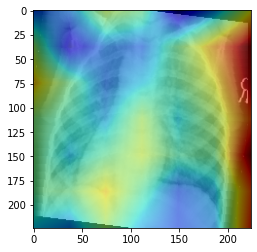

In [ ]:
test_image='/content/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1950_bacteria_4881.jpeg'
CAM_function(test_image)


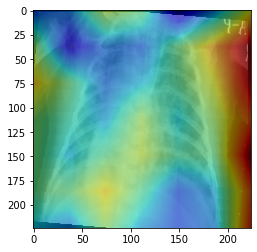

In [ ]:
test_image='/content/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg'
CAM_function(test_image)

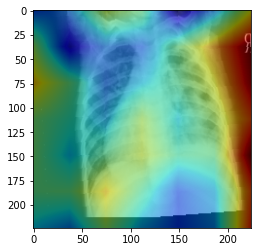

In [ ]:
test_image='/content/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg'
CAM_function(test_image)

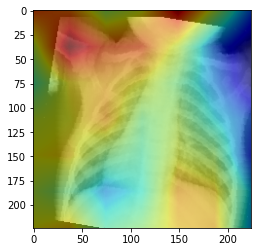

In [ ]:
test_image='/content/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg'
CAM_function(test_image)

In [ ]:
test = ImageFolder(data_dir+'/test', 
                      transform=tt.Compose([tt.Resize((224,224)),
                                            #tt.CenterCrop(224),
                                            tt.RandomHorizontalFlip(),
                                            tt.RandomRotation(10),
                                            tt.RandomGrayscale(),
                                            tt.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            tt.ToTensor()
                                           ]))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test, batch_size*2), device)
result = evaluate(model1, test_loader)
result

{'val_acc': 0.8075893521308899, 'val_loss': 0.5204803347587585}

**we** got 78.99% of test accuracy


Image number: 0 Target: NORMAL
Predicted: PNEUMONIA


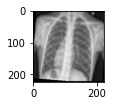

Image number: 1 Target: NORMAL
Predicted: PNEUMONIA


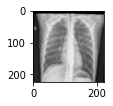

Image number: 2 Target: NORMAL
Predicted: PNEUMONIA


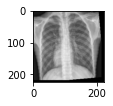

Image number: 3 Target: NORMAL
Predicted: PNEUMONIA


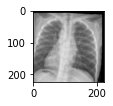

Image number: 4 Target: NORMAL
Predicted: PNEUMONIA


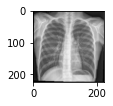

Image number: 5 Target: NORMAL
Predicted: NORMAL


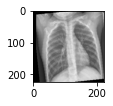

Image number: 6 Target: NORMAL
Predicted: PNEUMONIA


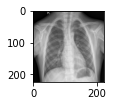

Image number: 7 Target: NORMAL
Predicted: PNEUMONIA


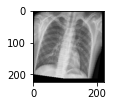

Image number: 8 Target: NORMAL
Predicted: PNEUMONIA


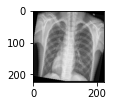

Image number: 9 Target: NORMAL
Predicted: PNEUMONIA


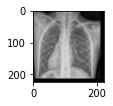

Image number: 10 Target: NORMAL
Predicted: PNEUMONIA


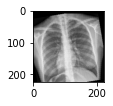

Image number: 11 Target: NORMAL
Predicted: PNEUMONIA


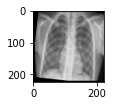

Image number: 12 Target: NORMAL
Predicted: PNEUMONIA


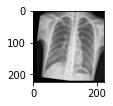

Image number: 13 Target: NORMAL
Predicted: PNEUMONIA


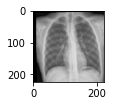

Image number: 14 Target: NORMAL
Predicted: PNEUMONIA


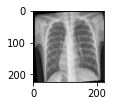

Image number: 15 Target: NORMAL
Predicted: PNEUMONIA


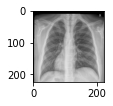

In [ ]:
show_predict(test)

In [ ]:
torch.save(model1.state_dict(), 'pneumoniaTf1.pth')

In [ ]:
model2 = to_device(TransferModel(), device)

In [ ]:
model2.load_state_dict(torch.load('pneumoniaTf1.pth'))

<All keys matched successfully>

In [ ]:
evaluate(model2, test_loader)

{'val_acc': 0.796875, 'val_loss': 0.5334696173667908}

We got the accuracy around 80% on test dataset.


Model: ResNet152

Image size:224x224

Batch_size=64

Epochs:16

Training accuracy:95.89%(approx)

Test accuracy:80.7%(approx)